In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from radar_simulation import ChirpConfiguration
from radar_simulation import MIMOConfiguration
from radar_simulation import FMCWMIMORadar
from radar_simulation import TargetObject
from signal_processing import RangeDopplerFFT
from signal_processing import BeamFormingDOA
from sensor import MIMOVirtualArray

In [ ]:
# (0) setup
# (0.1) 4x4-URA
num_tx = 4
txl = np.zeros((num_tx, 3))
txl[:,2] = np.arange(num_tx, dtype=np.int32)
num_rx = 4
rxl = np.zeros((num_rx, 3))
rxl[:,0] = np.arange(num_rx, dtype=np.int32)
# (0.2) configuration
cc = ChirpConfiguration()
mc = MIMOConfiguration(txl, rxl, cc.start_lambda, 0.5)
radar = FMCWMIMORadar(cc, mc)
mva = MIMOVirtualArray(mc)
# (0.3) object
objs = list()
objs.append(TargetObject.get_3d_target(7, 1, (5, -10)))
objs.append(TargetObject.get_3d_target(17, -2, (-5, 10)))

In [ ]:
# (1) do simulation
num_frames = 10
dc = radar.get_data_cube(num_frames, objs)

Text(0.5, 0, 'Range [m]')

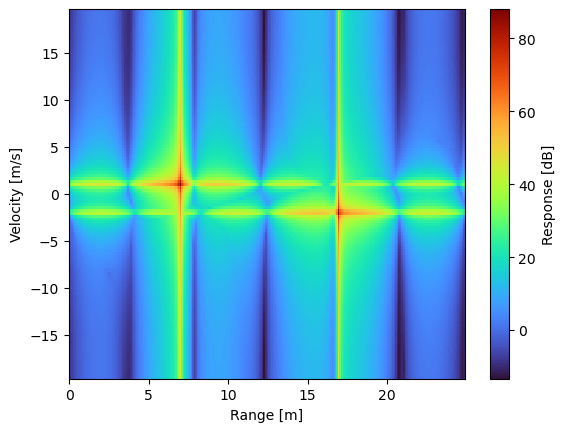

In [ ]:
postproc = RangeDopplerFFT()
rdm = postproc.get_2d_fft(dc)

target_frame = 0
rdm0_dB = np.mean(20 * np.log10((np.abs(rdm[target_frame,:,:,:,:]))), (1, 0))

range_bin = postproc.get_range_bins(cc)
velocity_bin = postproc.get_velocity_bins(cc)

fig, ax = plt.subplots()
cm = ax.pcolor(range_bin, velocity_bin, rdm0_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_ylabel('Velocity [m/s]')
ax.set_xlabel('Range [m]')

In [ ]:
# in realistic case use somewhat detection method like the CFAR
d_range, d_doppler = (72, 174), (67, 57)

bf = BeamFormingDOA(mva, 128)
angle_bins_el, angle_bins_az = bf.get_angle_bins()
angle_bins_el_degrees = np.rad2deg(angle_bins_el)
angle_bins_az_degrees = np.rad2deg(angle_bins_az)

angle_spectrum = list()
for k, l in zip(d_range, d_doppler):
    signal = mva.get_signal_padded(rdm[target_frame,:,:,l,k])
    s = bf.get_angle_fft(signal)
    angle_spectrum.append(s)

rm = postproc.get_1d_fft(dc)
ram = np.empty((rm.shape[4], bf.angle_fft_size), dtype=rm.dtype)
for k in range(ram.shape[0]):
    signal = mva.get_signal_padded(rm[target_frame,:,:,:,k])
    signal = np.mean(signal, axis=-1)
    s = bf.get_angle_fft(signal)
    s = np.mean(s, axis=0) # azimuth only
    ram[k,:] = s

Object 1, Theta: 5.379378991111861, Phi: -9.941077947065368, R:7.026385734375
Object 2, Theta: -5.379378991112252, Phi: 9.941077947064977, R:16.98043219140625


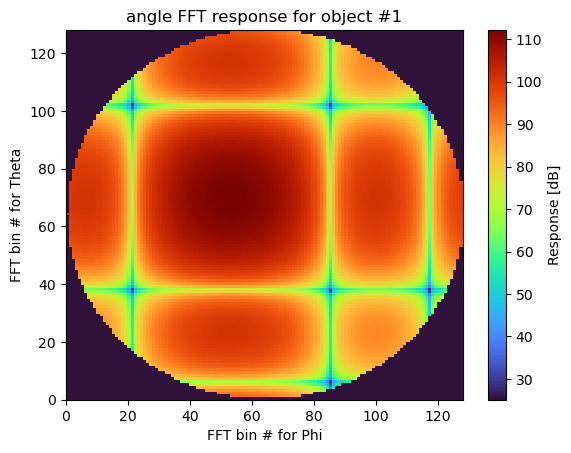

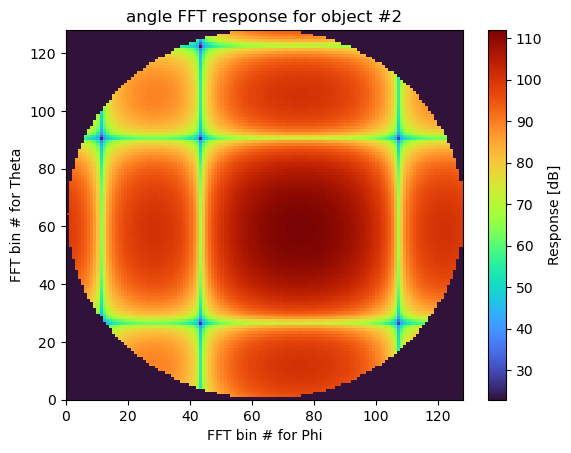

In [ ]:
az_bin = angle_bins_az_degrees.shape[0] // 2

angle_spectrum_power_dB = list()
for s in angle_spectrum:
    p = 20 * np.log10(np.abs(s))
    angle_spectrum_power_dB.append(p)

valid_angle_mask = mva.get_valid_angle_mask(angle_bins_az)
invalid_mask = np.invert(valid_angle_mask)
for k in range(len(angle_spectrum_power_dB)):
    s_masked = np.copy(angle_spectrum_power_dB[k])
    invalid = np.min(s_masked)
    s_masked[invalid_mask] = invalid
    fig, ax = plt.subplots()
    cm = ax.pcolor(s_masked, cmap='turbo')
    fig.colorbar(cm, ax=ax, label='Response [dB]')
    ax.set_xlabel('FFT bin # for Phi')
    ax.set_ylabel('FFT bin # for Theta')
    ax.set_title('angle FFT response for object #{}'.format(k + 1))

    el_max, az_max = np.unravel_index(np.argmax(s_masked), s_masked.shape)
    print('Object {}, Theta: {}, Phi: {}, R:{}'.format(k + 1, angle_bins_el_degrees[el_max], angle_bins_az_degrees[el_max, az_max], range_bin[d_range[k]]))


Text(0, 0.5, 'Range [m]')

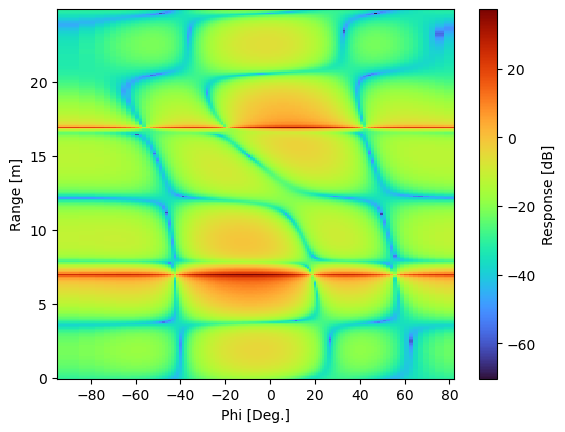

In [ ]:
ram_dB = 20 * np.log10(np.abs(ram))

fig, ax = plt.subplots()
cm = ax.pcolor(angle_bins_az_degrees[az_bin], range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_xlabel('Phi [Deg.]')
ax.set_ylabel('Range [m]')

Text(0, 0.5, 'Range [m]')

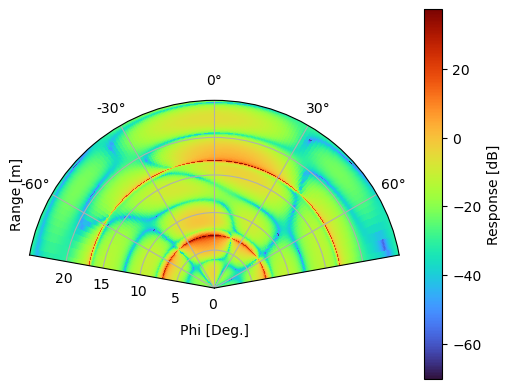

In [ ]:
lim_angle = np.max(angle_bins_az[az_bin])
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cm = ax.pcolor(angle_bins_az[az_bin], range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetalim([-lim_angle, lim_angle])
ax.set_xlabel('Phi [Deg.]', labelpad=-40)
ax.set_ylabel('Range [m]')